In [2]:
import torch

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import pytorch_lightning.callbacks as cb

from models.configurations import TEXT_PRETRAINED, VISION_PRETRAINED
from models.finetuner import AdaptorFinetuner
from models.adaptor import Adaptor
from utils.model_utils import get_newest_ckpt, StreamingProgressBar
from dataset.dataset import clf_collator
from dataset.configurations import DATASET_CFG
from dataset.data_module import AdaptorDataModule
from utils.args import get_train_parser
from utils.model_utils import load_vision_model

import numpy as np

In [3]:
vision_model = "dinov2-s"
text_model = "biobert"
dataset = "covidx"

vision_model_config = VISION_PRETRAINED[vision_model]
vision_pretrained = vision_model_config["pretrained_weight"]
vision_model_type = vision_model_config["vision_model_type"]

dataset_cfg = DATASET_CFG["clf"][dataset]
dataset_class = dataset_cfg["class"]
dataset_kwargs = dataset_cfg["kwargs"]
data_transform = vision_model_config["data_transform"]

In [4]:
adaptor_ckpt = get_newest_ckpt(
    vision_model, text_model, postfix="v2", 
    project_name="adaptor_pretrain_2_layers", 
)

adaptor = Adaptor.load_from_checkpoint(adaptor_ckpt)
backbone = load_vision_model(
    vision_model_type=vision_model_type,
    vision_pretrained=vision_pretrained,
    retain_head=False,
)

Using cache found in /homes/jq619/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [5]:
model = AdaptorFinetuner(
    backbone=backbone,
    adaptor=adaptor,
    model_name=vision_model,
    text_model_name=None,
    in_features=adaptor.projection_dim,
    num_classes=dataset_cfg["num_classes"],
    # num_layers=args.num_layers,
    hidden_dim=769,
    dropout=0.1,
    learning_rate=1e-4,
    weight_decay=1e-4,
    binary=dataset_cfg["binary"],
    multilabel=dataset_cfg["multilabel"],
)

In [6]:
model.linear_layer = torch.nn.Identity()
model.eval()

AdaptorFinetuner(
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (backbone): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0): NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate=none)
          (fc2): Linear(in_fe

In [7]:
trainer = Trainer(
    precision=16, 
    max_epochs=1, 
)

data_module = AdaptorDataModule(
    dataset=dataset_class,
    collate_fn=clf_collator,
    transforms=data_transform,
    data_pct=1.0,
    batch_size=16,
    num_workers=1,
    crop_size=224,
    seed=1117,
    **dataset_kwargs,
)
data_module.setup(stage="test")

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [9]:
from tqdm import tqdm
from math import ceil


n_samples = 1600
total_steps = ceil(n_samples//data_module.batch_size)
i = 0

embeddings_list = []
labels_list = []

# Ensure no gradients are computed
with torch.no_grad():
    for batch in tqdm(data_module.test_dataloader(), 
                      total=total_steps):
        if i == total_steps:
            break
        # Extract data from batch (depends on your data format)
        inputs, labels = batch['pixel_values'], batch['labels']
        # Move inputs to device (GPU if available)
        inputs = inputs.to(model.device)
        # Get embeddings
        pre_adaptor_embeddings = model.backbone(inputs)
        embeddings = model.adaptor(pre_adaptor_embeddings)
        # Convert embeddings to numpy and store
        embeddings_list.append(embeddings.cpu().numpy())
        labels_list.append(labels.cpu().numpy())
        
        i += 1

  2%|▏         | 2/100 [00:19<15:45,  9.65s/it]

In [ ]:
data_module._get_dataloader(split="test", shuffle=True)

TypeError: AdaptorDataModule._get_dataloader() got an unexpected keyword argument 'shuffle'

In [ ]:
all_embeddings = np.concatenate(embeddings_list, axis=0)
labels = np.concatenate(labels_list, axis=0)

# Save embeddings to .npy file
# np.save('embeddings.npy', all_embeddings)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, verbose=1, perplexity=50, n_iter=1000)

In [29]:
tsne_results = tsne.fit_transform(all_embeddings)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.001s...
[t-SNE] Computed neighbors for 1600 samples in 0.530s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 0.373872
[t-SNE] KL divergence after 50 iterations with early exaggeration: 70.203896
[t-SNE] KL divergence after 1000 iterations: 1.996757


<Axes: xlabel='x', ylabel='y'>

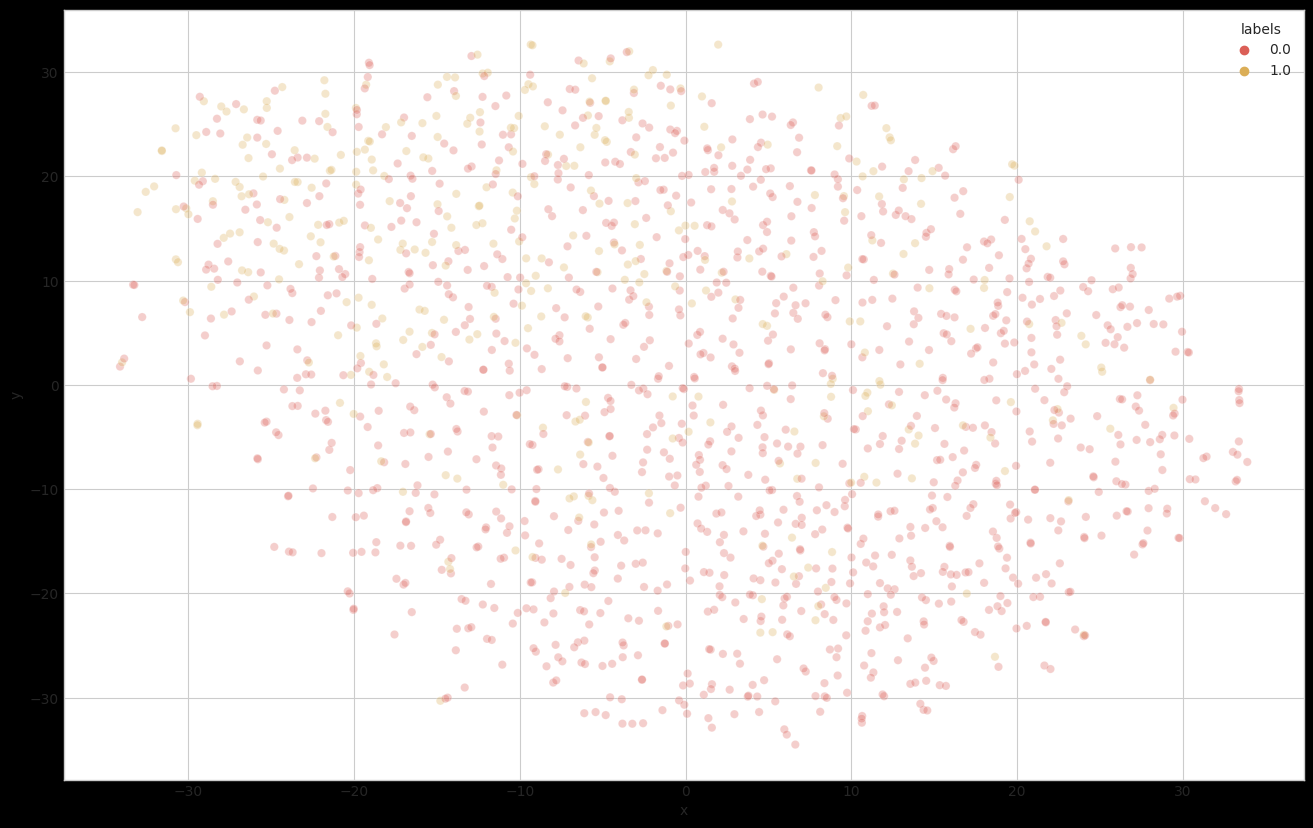

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

tsne_df = pd.DataFrame(np.c_[tsne_results, labels.astype(np.uint8)], 
                       columns=['x', 'y', 'labels'])

plt.figure(figsize=(16, 10))
plt.style.use('seaborn-whitegrid')
sns.scatterplot(
    x="x", y="y",
    hue="labels",
    palette=sns.color_palette("hls", 10),
    data=tsne_df,
    legend="full",
    alpha=0.3
)